In [1]:
import yaml
import healpy as hp
import numpy as np
import os
import scipy

from plancklens import utils

from jointmap.plots import CMBLensingPlot 

from delensalot.core import cachers

import os
import numpy as np

from delensalot.core.iterator import statics

import yaml

import matplotlib.pyplot as plt



mpisupport: False, pmisupport: False
disabling mpi
Using lenspyx alm2map


In [2]:
def bin_theory(cl, bin_edges):
    l = np.arange(len(cl))
    sums = scipy.stats.binned_statistic(l, l, statistic="sum", bins=bin_edges)
    cl = scipy.stats.binned_statistic(l, l*cl, statistic="sum", bins=bin_edges)
    cl = cl[0] / sums[0]
    el = (bin_edges[1:] + bin_edges[:-1])/2
    return el, cl


bin_edges = np.arange(10, 4000, 20)


def cross_corr_coeff(a, b, base=0, color=None, plot=True, ax=None, label=None):
    ls = np.arange(len(hp.alm2cl(a)))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(hp.alm2cl(a, b))
    el, aa = decorator(hp.alm2cl(a, a))
    el, bb = decorator(hp.alm2cl(b, b))
    xcorr = x**2 / (aa * bb)
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label)
    return el, xcorr

In [3]:
def load_config(file_path):
    with open(file_path, 'r') as file:
        return yaml.safe_load(file)
    

def load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx = 0):
    #input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_olm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    input_names = {"p": f"sim_{simidx:04}_plm", "o": f"sim_{simidx:04}_alpha_lm", "f": f"sim_{simidx:04}_tau_lm", "a": f"sim_{simidx:04}_alpha_lm"}
    inputs = {}
    print("Inputs in", f"{scratch}/{cmbversion}")
    for k in selected:
        input = hp.read_alm(f"{scratch}/{cmbversion}/simswalpha/{input_names[k]}.fits")
        inputs[k] = utils.alm_copy(input, lmax=lmax_rec)
    return inputs


# Function to process a configuration and prepare data for plotting
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin = config["imin"]
    simidx = imin
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"
    print("Reading from", its_folder)
    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

In [4]:
def process_config_npy(config_path):

    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/joint_map_outputs/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    imin, imax = config["imin"], config["imax"]
    itmax = config["itmax"]
    qe_key = config["k"]

    its_file = f"{scratch}/total_qe_it_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    autoits = np.load(its_file)

    its_file = f"{scratch}/total_qe_it_cross_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    crossits = np.load(its_file)

    its_file = f"{scratch}/total_qe_it_cross_down_{qe_key}_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    if os.path.exists(its_file):
        crossits_down = np.load(its_file)
    else:
        crossits_down = 0

    its_file = f"{scratch}/input_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    auto_input_its = np.load(its_file)

    its_file = f"{scratch}/input_down_{version}_{cmbversion}_{imin}_{imax}_{itmax}.npy"
    if os.path.exists(its_file):
        auto_input_down_its = np.load(its_file)
    else:
        auto_input_down_its = 0


    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    
    return selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its



In [5]:
def process_config(config_path, itrs, subset_selected, simidx = 0):
    config = load_config(config_path)
    scratch = os.getenv("SCRATCH") + "/JOINTRECONSTRUCTION/"
    cmbversion = config["cmb_version"]
    version = config["v"]
    simidx = config["imin"]
    qe_key = config["k"]
    its_folder = f"{scratch}/{cmbversion}_version_{version}_recs/{qe_key}_sim{simidx:04}{version}/"

    print("Reading from", its_folder)

    recs = statics.rec()
    plms = recs.load_plms(its_folder, itrs=itrs)

    Nselected = len(config["selected"])
    lmax_rec = hp.Alm.getlmax(np.split(plms[0], Nselected)[0].shape[0])
    selected = list(map(lambda s: s[0] if len(s) == 2 else s, config["selected"]))
    subset_selected = [k for k in subset_selected if k in selected]
    inputs = load_inputs(config, selected, scratch, cmbversion, lmax_rec, simidx)
    title = config.get("title", f"Config: {os.path.basename(config_path)}")
    return selected, subset_selected, plms, inputs, lmax_rec, title

    

In [6]:
def plot_configs_with_class(config_paths, subset_selected, itrs, outname, input_dict):
    config_data = [process_config(config_path, itrs, subset_selected) for config_path in config_paths]

    N_configs = len(config_paths)
    rows = len(subset_selected)
    cols = N_configs

    names_fields = {"p": r"$\phi$", "o": r"$\omega$", "f": r"$\tau$", "a": r"$\alpha$"}

    # Initialize CMBLensingPlot
    plot = CMBLensingPlot(rows=rows, cols=cols, figsize=(10, 6), sharex=True, sharey = False, outdir = "../plots/")

    for i, k in enumerate(subset_selected):  # Iterate over estimators
        for j, (selected, _, plms, inputs, _, title) in enumerate(config_data):  # Iterate over configurations
            original_idx = selected.index(k)

            for idx, itr in enumerate(itrs):  # Iterate over iterations
                splits = np.split(plms[idx], len(selected))
                el, cross = cross_corr_coeff(splits[original_idx], inputs[input_dict[k]], plot=False)
                plot.add_curve(el, cross, label=f"itr {itr}", row=i, col=j, linewidth = 1.5)

            plot.set_labels(xlabel=r"$L$", ylabel=r"$\rho_L$" + f" ({names_fields[k]})", row=i, col=j)

            plot.set_scale(xscale="log", row=i, col=j)
            if i == 0:
                plot.set_title(title, row=i, col=j)
                if j == 0:
                    plot.set_legend(row=i, col=j, fontsize = 10)

    #plot.save_plot(outname, dpi=300)
    plot.show_plot()

In [13]:
dd = "/users/odarwish/scratch/JOINTRECONSTRUCTION/apof_new_version_apof_new_official_lensed_response_recs/p_p_sim0001apof_new_official_lensed_response/"

In [94]:
flm0_bh_norm = np.load(dd+"flm0_bh_norm.npy")
flm0 = np.load(dd+"flm0_norm.npy")
plm0 = np.load(dd+"plm0_norm.npy")

plminput = hp.read_alm("/users/odarwish/scratch/JOINTRECONSTRUCTION/apof_new/simswalpha/sim_0001_plm.fits")
plminput = utils.alm_copy(plminput, lmax = 5000)

tauinput = hp.read_alm("/users/odarwish/scratch/JOINTRECONSTRUCTION/apof_new/simswalpha/sim_0001_tau_lm.fits")
tauinput = utils.alm_copy(tauinput, lmax = 5000)

In [87]:
#take responses
Rpp, Rff, Rpf_unl, Rfp_unl, Rff_bh_p = np.loadtxt("resps.txt").T

In [83]:
R = 1/(1-Rfp_unl*Rpf_unl)
R[0] = 0
f_bh = hp.almxfl(flm0-hp.almxfl(plm0, Rfp_unl), R)
f_bh = flm0+hp.almxfl(plm0, Rpf_unl/Rff)

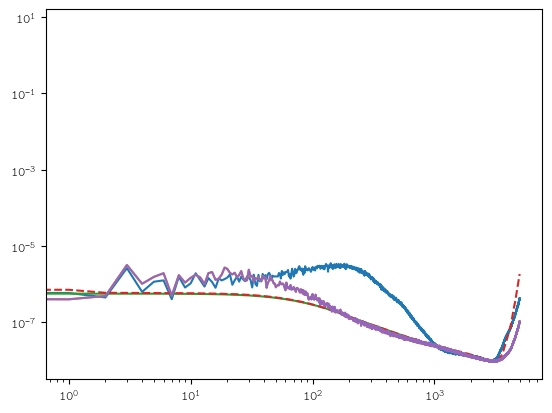

In [100]:
plt.loglog(hp.alm2cl(f_bh))
plt.loglog(hp.alm2cl(flm0))

plt.loglog(Rff**-1.)
plt.loglog(Rff_bh_p**-1., ls = "--")

plt.loglog(hp.alm2cl(flm0))

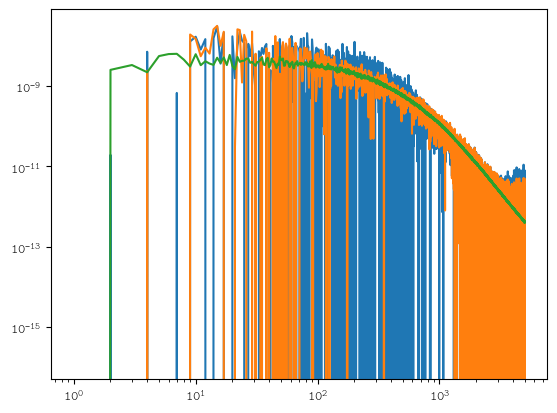

In [98]:
plt.loglog(hp.alm2cl(f_bh, tauinput))
plt.loglog(hp.alm2cl(flm0, tauinput))
plt.loglog(hp.alm2cl(tauinput))

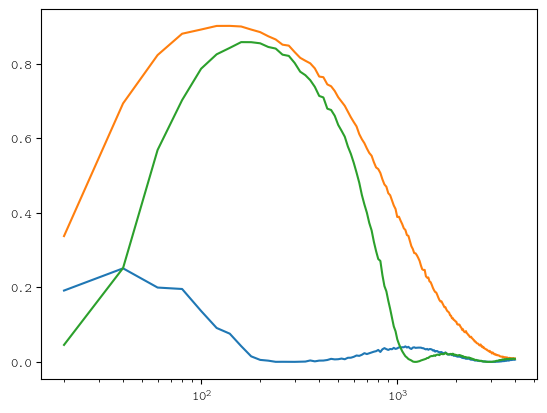

In [102]:
el, cross = cross_corr_coeff(flm0, plminput, plot=True)
el, cross_bh = cross_corr_coeff(flm0_bh_norm, plminput, plot=True)
el, bh = cross_corr_coeff(f_bh, plminput, plot=True)

plt.plot(el, cross)
plt.plot(el, cross_bh)
plt.plot(el, bh)
plt.xscale("log")

Reading from /scratch/snx3000/odarwish/JOINTRECONSTRUCTION//apof_new_version_apof_new_official_lensed_response_recs/p_p_sim0000apof_new_official_lensed_response/
Inputs in /scratch/snx3000/odarwish/JOINTRECONSTRUCTION//apof_new


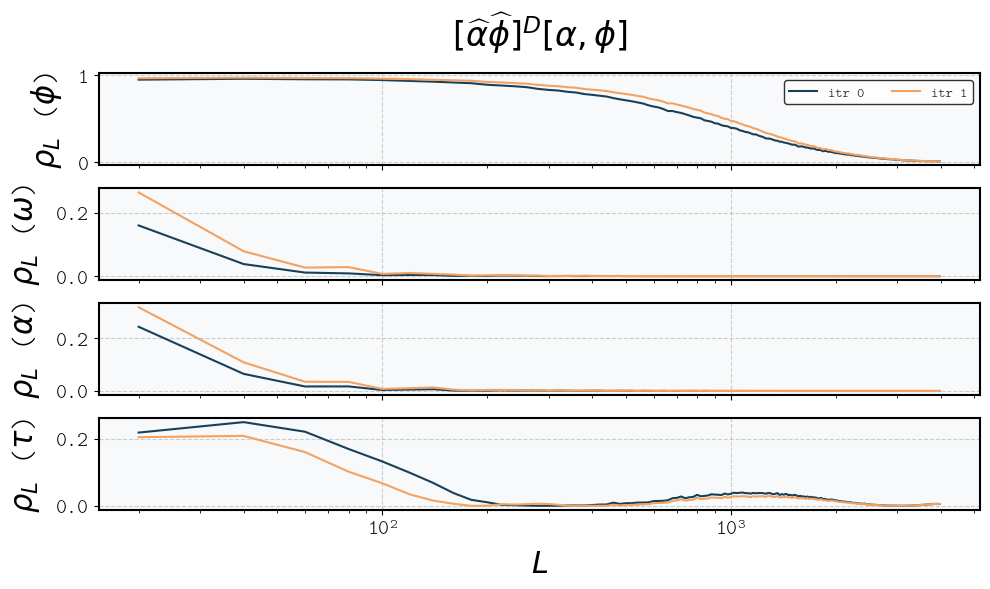

In [12]:
config_paths = ["official_multiple_len_resp"] #, "check_mv", "config_full_alpha_lensing_cmb_s4", "config_full_alpha_disabled_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

subset_selected = ["p", "o", "a", "f"]
itrs = [0, 1]#, 1, 2]#, 1, 5, 15]
outname = "d"

input_dict = {"p": "p", "o": "a", "f": "p", "a": "a"}
plot_configs_with_class(config_paths, subset_selected, itrs, outname, input_dict)

## Showing noise levels

In [10]:
from os.path import join as opj
import os
from plancklens import utils

import matplotlib.pyplot as plt


def camb_clfile_gradient(fname, lmax=None):
    """CAMB spectra (lenspotentialCls, lensedCls or tensCls types) returned as a dict of numpy arrays.
    Args:
        fname (str): path to CAMB output file
        lmax (int, optional): outputs cls truncated at this multipole.
    """
    cols = np.loadtxt(fname).transpose()
    ell = np.int_(cols[0])
    if lmax is None: lmax = ell[-1]
    assert ell[-1] >= lmax, (ell[-1], lmax)
    cls = {k : np.zeros(lmax + 1, dtype=float) for k in ['tt', 'ee', 'bb', 'te']}
    w = ell * (ell + 1) / (2. * np.pi)  # weights in output file
    idc = np.where(ell <= lmax) if lmax is not None else np.arange(len(ell), dtype=int)
    for i, k in enumerate(['tt', 'ee', 'bb', 'te']):
        cls[k][ell[idc]] = cols[i + 1][idc] / w[idc]
    return cls

cls_path = opj(os.environ['HOME'], 'fgcmblensing', 'input', 'giulio')
#cls_path = opj("/Users/omard/Downloads/", 'giulio')
cls_unl = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lenspotentialCls.dat'))
cls_len = utils.camb_clfile(opj(cls_path, 'lensedCMB_dmn1_lensedCls.dat'))
cls_grad = camb_clfile_gradient(opj(cls_path, 'lensedCMB_dmn1_lensedgradCls.dat'))
cls_rot = np.loadtxt(opj(cls_path, 'new_lensedCMB_dmn1_field_rotation_power.dat')).T[1]


##also, get some theory calculation for comparison
from plancklens import nhl, n0s, qresp

qe_key = "p_p"

nlev_t = 1.
nlev_p = nlev_t*np.sqrt(2)
beam_fwhm = 1.
cls_unl_fid = cls_unl
lmin_cmb = 30
lmin_blm, lmin_elm, lmin_tlm = 100, lmin_cmb, lmin_cmb
lmax_cmb = 4000
itermax = 1
ret_curl = True

lmax_qlm = 5120

lt, le, lb = (np.arange(lmax_cmb + 1) >= lmin_tlm), (np.arange(lmax_cmb + 1) >= lmin_elm), (np.arange(lmax_cmb + 1) >= lmin_blm)

transf = hp.gauss_beam(beam_fwhm / 180 / 60 * np.pi, lmax=lmax_cmb)
ftl = utils.cli(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt# isotropic approximation to the  T filtering, must match that applied to the data
fel = utils.cli(cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le # isotropic approximation to the E filtering
fbl = utils.cli(cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb # isotropic approximation to the P filtering
fals = {'tt':ftl, 'ee':fel, 'bb':fbl}
dat_cls = {'tt':(cls_len['tt'][:lmax_cmb + 1] + (nlev_t / 60. / 180. * np.pi) ** 2 / transf ** 2)*lt,
            'ee': (cls_len['ee'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*le,
               'bb': (cls_len['bb'][:lmax_cmb + 1] + (nlev_p / 60. / 180. * np.pi) ** 2 / transf ** 2)*lb}

cls_ivfs_arr = utils.cls_dot([fals, dat_cls, fals])

cls_ivfs = dict()
for i, a in enumerate(['t', 'e', 'b']):
    for j, b in enumerate(['t', 'e', 'b'][i:]):
        if np.any(cls_ivfs_arr[i, j + i]):
            cls_ivfs[a + b] = cls_ivfs_arr[i, j + i]

nggs = {}
for source in ["p", "a"]:
    qe_key = f"{source}_p"

    GG_N0, CC_N0 = nhl.get_nhl(qe_key, qe_key, cls_len, cls_ivfs, lmax_cmb, lmax_cmb, lmax_out = lmax_qlm)[0:2]

    r_gg_fid, r_cc_fid = qresp.get_response(qe_key, lmax_cmb, source, cls_len, cls_grad, fals, lmax_qlm = lmax_qlm)[0:2]

    n_gg = GG_N0 * utils.cli(r_gg_fid ** 2)

    nggs[source] = n_gg

    if source == "p":
        nggs["o"] = CC_N0*utils.cli(r_cc_fid ** 2)


In [11]:
from delensalot.biases import iterbiasesN0N1

qe_key = 'p_p'

cachedir = 'n0n1_cachedir_200_new_so'
nlev_t, nlev_p, beam_fwhm = 7, 7*np.sqrt(2), 1.4
itbias = iterbiasesN0N1.iterbiases(nlev_t, nlev_p, beam_fwhm, (lmin_cmb, lmin_cmb, lmin_cmb), lmax_cmb,
                                    lmax_qlm, cls_unl_fid, None, cachedir, verbose=True)
N0s_iter = {}
N1s_iter = {}
rggs_iter = {}
for itermax in [0, 5, 10]:
    A, del_cls, dat_del_cls = itbias.get_n0n1(qe_key, itermax, None, None, version = "wN1")
    N0s, N1s, rgg, _ = A
    N0s_iter[itermax] = N0s
    N1s_iter[itermax] = N1s
    rggs_iter[itermax] = rgg

lmin_tlm:30, lmin_elm:30, lmin_blm:30
Filtering with gaussian beam and fiducial noise levels


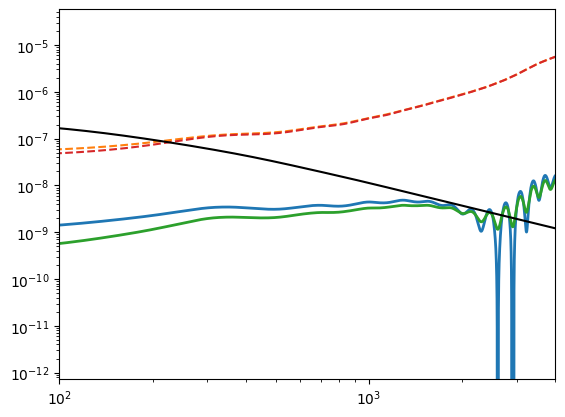

In [12]:
ls = np.arange(N1s_iter[itermax].size)
factor = ls*(ls+1)/2
for itermax in [0, 10]:
    plt.loglog(N1s_iter[itermax]*factor**2, lw = 2)
    plt.loglog(N0s_iter[itermax]*factor**2, ls = "--")
plt.plot(cls_unl["pp"][:ls.size]*factor**2, color = "black")
plt.xlim(100, 4000)
plt.savefig("n1.png", dpi = 300)

In [13]:
def compute_inner_sum(L, Lp, cls_ee, cls_ee_dat, cls_bb_dat, lmax_cmb):
    """
    Compute the inner summation of the N1 noise term.
    
    Args:
        L (int): Current L value
        Lp (int): Current L' value
        cls_ee (array): EE power spectrum
        cls_ee_dat (array): Observed EE power spectrum (including noise)
        cls_bb_dat (array): Observed BB power spectrum (including noise)
        lmax_cmb (int): Maximum CMB multipole
    
    Returns:
        float: Result of the inner summation
    """
    # Create array of ell values up to lmax_cmb
    ell = np.arange(lmax_cmb + 1)
    
    # Create mask for valid ells where 2ℓ ≥ max(L',L)
    # We compare 2ℓ with both L' and L to satisfy the condition
    min_ell = max(Lp, L)
    ell_mask = 2*ell >= min_ell
    
    # Add mask for valid spectrum values (avoid division by zero)
    valid_mask = (cls_ee_dat > 0) & (cls_bb_dat > 0)
    combined_mask = ell_mask & valid_mask
    
    # Compute the multiplier (2ℓ + 1)/(4π) for all valid ells at once
    ell_factor = (2*ell[combined_mask] + 1)/(4*np.pi)
    
    # Compute the ratio terms for all valid ells at once
    # Note that the formula has the same numerator (-2C_ℓ^EE) for both fractions
    ratio_ee = -2*cls_ee[combined_mask] / (cls_ee_dat[combined_mask])
    ratio_bb = -2*cls_ee[combined_mask] / (cls_bb_dat[combined_mask])
    
    # Combine everything and sum
    # We multiply the ratios first, then square the result
    inner_sum = np.sum(ell_factor * (ratio_ee * ratio_bb)**2)
    
    return inner_sum

def compute_Lp_prefactor(Lp, cls_kk):
    """
    Compute the L' dependent prefactor for a single L' value:
    (2L' + 1)/(4π) * C_L'^κκ * (1/2) * (L'-1)(L'+2)/(L'(L'+1))
    
    Args:
        Lp (int): Single L' value 
        cls_kk (array): Convergence power spectrum C_L^κκ
        
    Returns:
        float: Prefactor for the given L' value
    """
    # Return zero if L' is 0 to avoid division by zero
    if Lp == 0:
        return 0.0
    
    # Calculate each term separately for clarity
    # First term: (2L' + 1)/(4π)
    first_term = (2*Lp + 1)/(4*np.pi)
    
    # Second term: C_L'^κκ
    second_term = cls_kk[Lp]
    
    # Third term: (1/2) * (L'-1)(L'+2)/(L'(L'+1))
    numerator = (Lp - 1) * (Lp + 2)
    denominator = Lp * (Lp + 1)
    third_term = 0.5 * numerator / denominator
    
    return first_term * second_term * third_term


def compute_n1_term(L, cls_kk, cls_ee, cls_ee_dat, cls_bb_dat, lmax_cmb):
    """
    Compute the complete N1 noise term for a given L
    
    Args:
        L (array): Array of L values to compute N1 for
        cls_kk (array): Convergence power spectrum
        cls_ee (array): EE power spectrum
        cls_ee_dat (array): Observed EE spectrum (including noise)
        cls_bb_dat (array): Observed BB spectrum (including noise)
        lmax_cmb (int): Maximum CMB multipole
    
    Returns:
        array: N1 noise term for each input L value
    """
    # Initialize result array
    result = np.zeros_like(L, dtype=float)
    
    # For each L value
    for i, curr_L in enumerate(L):
        # Sum over L' values
        for Lp in range(1, lmax_cmb + 1):  # Start from 1 to avoid division by zero
            # Compute the L' prefactor - now takes a single value
            prefactor = compute_Lp_prefactor(Lp, cls_kk)
            
            # Compute the inner sum over ℓ
            inner_sum = compute_inner_sum(curr_L, Lp, cls_ee, cls_ee_dat, 
                                        cls_bb_dat, lmax_cmb)
            
            # Multiply and add to result
            result[i] += prefactor * inner_sum
    
    return result

def n1_beta_beta(L, cls_unl, dat_cls, fals, lmax_cmb):
    """
    Calculate n_L^(1)ββ by summing n_LL'^(1)ββ over L'. This uses our previously
    defined helper functions to maintain code clarity and modularity.
    
    Args:
        L (array): Multipole array to compute N1 for
        cls_unl (dict): Unlensed CMB power spectra including 'pp' (lensing potential)
        dat_cls (dict): Data (observed) power spectra including noise
        fals (dict): Filtering functions (not used in this implementation)
        lmax_cmb (int): Maximum CMB multipole for summation
        
    Returns:
        array: N1 noise term for each input L value
    """
    # First, prepare the convergence power spectrum from the lensing potential
    cls_pp = cls_unl['pp'][:lmax_cmb + 1]
    ell = np.arange(len(cls_pp))
    conv_factor = np.zeros_like(ell, dtype=float)
    conv_factor[1:] = (ell[1:] * (ell[1:] + 1) / 2) ** 2
    cls_kk = cls_pp * conv_factor

    # Prepare the E-mode spectra
    cls_ee = cls_len['ee'][:lmax_cmb + 1]  # Assuming cls_len is defined
    cls_ee_dat = dat_cls['ee'][:lmax_cmb + 1]
    cls_bb_dat = dat_cls['bb'][:lmax_cmb + 1]

    # Now we can use our compute_n1_term function which internally uses
    # compute_Lp_prefactor and compute_inner_sum
    return compute_n1_term(L[:10], cls_kk, cls_ee, cls_ee_dat, cls_bb_dat, lmax_cmb)

#######################

def n0_beta_beta_inverse(L, cls_unl, dat_cls, fals, lmax_cmb):
    """
    Calculate 1/N_L^(0)ββ for CMB lensing noise calculation using real spectra.
    
    Args:
        L (array): Multipole array
        cls_unl (dict): Unlensed CMB power spectra
        dat_cls (dict): Data (observed) power spectra including noise
        fals (dict): Filtering functions
        lmax_cmb (int): Maximum CMB multipole for summation
    """
    # Truncate spectrum to lmax_cmb
    cls_ee = cls_len['ee'][:lmax_cmb + 1]
    
    # Get the filtered spectra
    filtered_ee = cls_ee
    
    cls_ee_dat = dat_cls['ee']
    cls_bb_dat = dat_cls['bb']
    
    result = np.zeros_like(L, dtype=float)
    
    for l in range(lmax_cmb + 1):
        if cls_ee_dat[l] != 0 and cls_bb_dat[l] != 0:
            result += ((2*l + 1)/(4*np.pi)) * \
                     ((filtered_ee[l]/cls_ee_dat[l]) * (filtered_ee[l]/cls_bb_dat[l]))
    
    return 4 * result

def calculate_noise_terms(lmax_cmb, cls_unl, dat_cls, fals):
    """
    Calculate both noise terms using the provided spectra and filters.
    
    Args:
        lmax_cmb (int): Maximum CMB multipole
        cls_unl (dict): Unlensed CMB power spectra
        dat_cls (dict): Data (observed) power spectra including noise
        fals (dict): Filtering functions
        
    Returns:
        tuple: (n1_bb, n0_bb_inv) arrays
    """
    L = np.arange(lmax_cmb + 1)
    
    # Calculate N1 term
    n1_bb = n1_beta_beta(L, cls_unl, dat_cls, fals, lmax_cmb)
    
    # Calculate inverse N0 term
    n0_bb_inv = n0_beta_beta_inverse(L, cls_unl, dat_cls, fals, lmax_cmb)
    
    return n1_bb, n0_bb_inv**-1.

n1_bb, n0_bb = calculate_noise_terms(lmax_cmb, cls_unl, dat_cls, fals)

In [14]:
directory = "/users/odarwish/scratch/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot_version_alpha_phi_cmb_new_rot_test_jan_4_recs/p_p_sim0000alpha_phi_cmb_new_rot_test_jan_4/"
directorycmb = "/users/odarwish/scratch/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot/simswalpha/"
alm0_norm = np.load(directory+"alm0_norm.npy")
alm0_input = hp.read_alm(directorycmb+"sim_0000_alpha_lm.fits")
plm0_input = hp.read_alm(directorycmb+"sim_0000_plm.fits")

phi_plm = np.load("/users/odarwish/scratch/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot_version_alpha_phi_cmb_new_rot_test_jan_4_recs/p_p_sim0000alpha_phi_cmb_new_rot_test_jan_4/phi_plm_it000.npy")
alm0_plm = np.split(phi_plm, 3)[0]

In [280]:
phi_norm_alm0_zero = np.load("/users/odarwish/scratch/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot_version_alpha_phi_cmb_new_rot_test_jan_3_recs/p_p_sim0000alpha_phi_cmb_new_rot_test_jan_3/phi_plm_it000.npy")

alm0_zero = np.split(phi_norm_alm0_zero, 3)[0]

results = []
result = alm0_zero
for i in range(5):
    hlm = np.load(f"/users/odarwish/scratch/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot_version_alpha_phi_cmb_new_rot_test_jan_3_recs/p_p_sim0000alpha_phi_cmb_new_rot_test_jan_3/hessian/rlm_sn_{i}_p.npy")
    delta_alm0_zero = np.split(hlm, 3)[0]
    #print(i, delta_alm0_zero)
    result += delta_alm0_zero
    results.append(delta_alm0_zero)
results = np.cumsum(results, axis = 0)

In [281]:
alm0_input_ = utils.alm_copy(alm0_input, lmax = 5000)

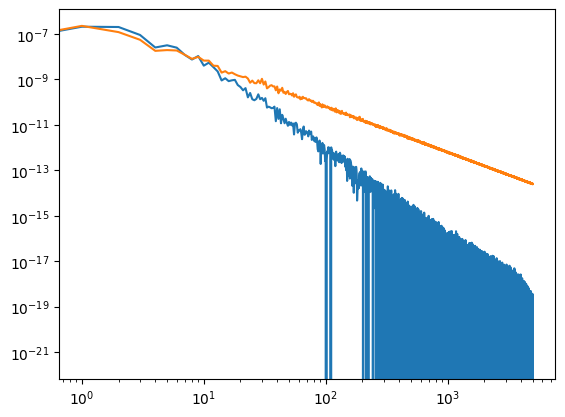

In [282]:
plt.loglog(hp.alm2cl(result, alm0_input_))
plt.loglog(hp.alm2cl(alm0_input_, alm0_input_))

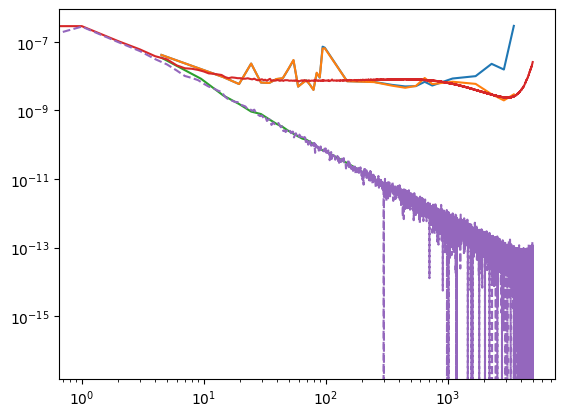

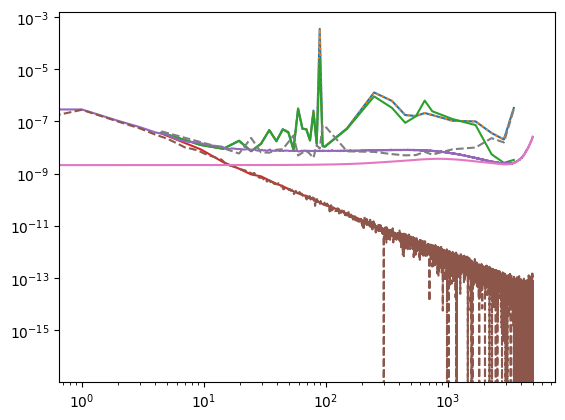

In [283]:


el, cross = decorator(hp.alm2cl(alm0_plm, alm0_input_))
el, auto = decorator(hp.alm2cl(alm0_plm))
el, input = decorator(hp.alm2cl(alm0_input_))
WF = cross/input

WFQE = WF

plt.loglog(el, auto*WF**-2)
qe = auto*WF**-2


el, cross = decorator(hp.alm2cl(alm0_plm, alm0_len_))
WF = cross/input

WFQE_len = WF
plt.loglog(el, auto*WF**-2)




plt.plot(el, input)

plt.plot(qe_split[-1])
plt.plot(qe_cross_split[-1], ls = "--")

plt.show()

result = results[-1]
el, cross = decorator(hp.alm2cl(result, alm0_input_))
el, auto = decorator(hp.alm2cl(result))
el, input = decorator(hp.alm2cl(alm0_input_))
WF = cross/input
plt.loglog(el, auto*WF**-2)

result = results[-1]
el, cross = decorator(hp.alm2cl(result, alm0_input_))
el, auto = decorator(hp.alm2cl(result))
el, input = decorator(hp.alm2cl(alm0_input_))
WF = cross/input
WFiter = WF
plt.loglog(el, auto*WF**-2, ls = ":")


el, cross = decorator(hp.alm2cl(result, alm0_len_))
WF = cross/input
plt.loglog(el, auto*WF**-2)

WFiter_len = WF


plt.plot(el, input)

plt.plot(qe_split[-1])
plt.plot(qe_cross_split[-1], ls = "--")

plt.plot(ngg_10)

plt.plot(el, qe, ls = "--")

plt.show()

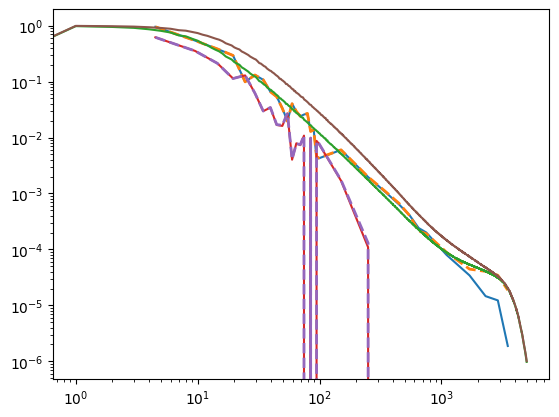

In [284]:
plt.loglog(el, WFQE)

plt.plot(el, WFQE_len, lw = 2, ls = "--")

plt.plot(WFth)

plt.plot(el, WFiter)
plt.plot(el, WFiter_len, lw = 2, ls = "--")
plt.plot(WFth10)

In [29]:
def _get_dlm(idx):
    dlm = plm0_input.copy()
    dclm = np.zeros_like(plm0_input)
    lmax_dlm = hp.Alm.getlmax(dlm.size, -1)
    mmax_dlm = lmax_dlm
    # potentials to deflection
    p2d = np.sqrt(np.arange(lmax_dlm + 1, dtype=float) * np.arange(1, lmax_dlm + 2, dtype=float))
    #p2d[:self.lmin_dlm] = 0
    hp.almxfl(dlm, p2d, mmax_dlm, inplace=True)
    hp.almxfl(dclm, p2d, mmax_dlm, inplace=True)
    return dlm, dclm, lmax_dlm, mmax_dlm

In [32]:
dlm, dclm, lmax_dlm, mmax_dlm = _get_dlm(0)

import lenspyx
from plancklens import shts
lmax_map = hp.Alm.getlmax(alm0_input.size)
nside_lens = 2048
a0_len = lenspyx.alm2lenmap(
    alm0_input, [dlm, None], geometry=('healpix', {'nside': nside_lens}),
    epsilon=1e-8, verbose=0)
alm0_len = shts.map2alm(a0_len, lmax = lmax_map)

In [54]:
alm0_len_ = utils.alm_copy(alm0_len, lmax = 5000)
alm0_input_ = utils.alm_copy(alm0_input, lmax = 5000)

In [45]:
from lenspyx.remapping.utils_geom import Geom 
from lenspyx.remapping import deflection
lenjob_geometry = Geom.get_thingauss_geometry(6000, 2)
f = deflection(lenjob_geometry, dlm, mmax_dlm,
                epsilon=1e-8)
alm0_len_2 = f.lensgclm(alm0_input, mmax_dlm, 0, lmax_map, lmax_map)

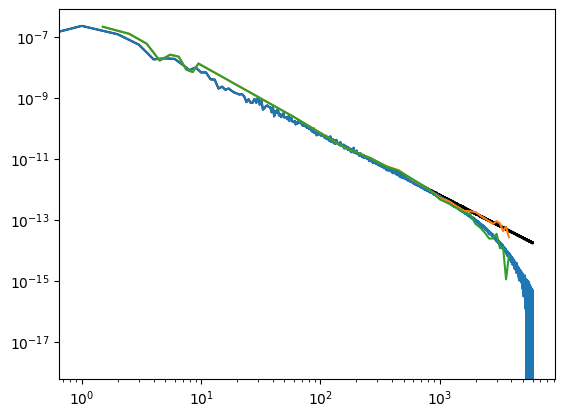

In [57]:
plt.loglog(hp.alm2cl(alm0_input), color = "black")

plt.loglog(hp.alm2cl(alm0_len, alm0_input))

el, x = decorator(hp.alm2cl(alm0_len_, alm0_norm))
plt.plot(el, x)

el, x = decorator(hp.alm2cl(alm0_input_, alm0_norm))
plt.plot(el, x)

In [11]:
config_paths = ["config_full_alpha_lensing_cmb_s4", "config_full_alpha_disabled_lensing_cmb_s4", "config_full_alpha_no_curl_lensing_cmb_s4", "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]


config_paths = ["alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]
config_paths

['configs/alpha_after_lensing_sims.yaml',
 'configs/config_full_alpha_disabled_lensing_cmb_s4_new_rotation.yaml',
 'configs/config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est.yaml']

In [25]:
#bin_edges = np.arange(1, 4000, 2)
#bin_edges_A = np.arange(5, 10, 2)
bin_edges_B = np.arange(5, 500, 50)
bin_edges = np.concatenate([bin_edges_B, np.arange(500, 4000, 200)])

decorator = lambda x: bin_theory(x, bin_edges)


In [13]:
selected = ["a", "p", "o"]

In [14]:
NN = 4

ffmean = 0
ff1000mean = 0

Ncases = 4
ff1000means = {i: 0 for i in range(Ncases+1)}
ffmeans = {i: 0 for i in range(Ncases+1)}

for simnumber in range(NN):
    directory = f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot_version_alpha_phi_cmb_new_rot_test_jan_4_recs/p_p_sim{simnumber:04}alpha_phi_cmb_new_rot_test_jan_4/"

    root = "plm_gradplik_it000"
    #root = "phi_plm_it000"
    #roots = ["plm_gradplik_it000", "phi_plm_it000"]
    roots = ["phi_plm_it000"]+[f"hessian/rlm_sn_{i}_p" for i in range(Ncases)]

    #roots = ["plm_gradplik_it000"]

    alpha_lm = hp.read_alm(f"/scratch/snx3000/odarwish/JOINTRECONSTRUCTION/alpha_phi_cmb_new_rot/simswalpha/sim_{simnumber:04}_alpha_lm.fits")
    alpha_lm = utils.alm_copy(alpha_lm, lmax = lmax_qlm)
    fs = np.cumsum([np.load(directory+f"{root}.npy") for root in roots], axis = 0)
    fs1000 = np.cumsum([np.load(directory+f"{root}_1000_1000.npy") for root in roots], axis = 0)

    for i in range(Ncases+1):
        xx = 0
        ff = np.split(fs[i], 3)[xx]
        ff1000 = np.split(fs1000[i], 3)[xx]

        #ffmean += hp.alm2cl(ff)
        #ff1000mean += hp.alm2cl(ff1000)
        ffmeans[i] += hp.alm2cl(ff)
        ff1000means[i] += hp.alm2cl(ff1000)

for i in range(Ncases):
    ff1000means[i] /= NN
    ffmeans[i] /= NN

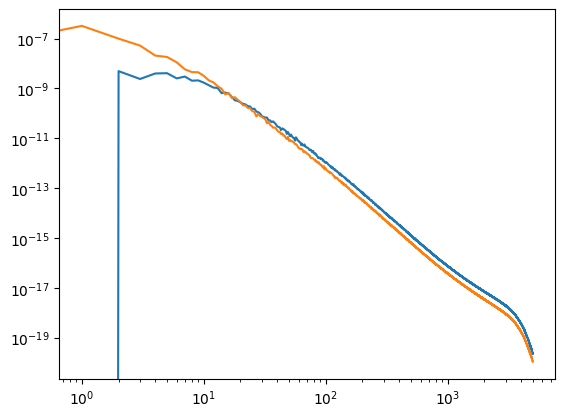

In [22]:
ii = 0
#plt.loglog(ff1000means[ii])
#plt.loglog(ffmeans[ii])

ii = 3
plt.loglog(ff1000means[ii])
plt.loglog(ffmeans[ii])

In [16]:
inputs_ = np.load("/users/odarwish/scratch/joint_map_outputs/input_alpha_disabled_phi_omega_alpha_phi_omega_cmb_0_127_15.npy")
input_ = np.mean(inputs_, axis = 0)

In [208]:
qe = np.load("/users/odarwish/scratch/joint_map_outputs/total_qe_p_p_p_o_a_test_p_o_a_test_0_31_1.npy")
qe_cross = np.load("/users/odarwish/scratch/joint_map_outputs/total_qe_cross_p_p_p_o_a_test_p_o_a_test_0_31_1.npy")

qe_it = np.load("/users/odarwish/scratch/joint_map_outputs/total_qe_it_p_p_p_o_a_test_p_o_a_test_0_31_1.npy")
qe_cross_it = np.load("/users/odarwish/scratch/joint_map_outputs/total_qe_it_cross_p_p_p_o_a_test_p_o_a_test_0_31_1.npy")


qe = qe.mean(axis = 0)
qe_cross = qe_cross.mean(axis = 0)

qe_it_single = qe_it[0]

qe_it = qe_it.mean(axis = 0)
qe_cross_it = qe_cross_it.mean(axis = 0)

qe_split = np.split(qe, 3)
qe_cross_split = np.split(qe_cross, 3)

qe_it_single_split = np.split(qe_it_single, 3, axis = -1)
qe_it_split = np.split(qe_it, 3, axis = -1)
qe_cross_it_split = np.split(qe_cross_it, 3, axis = -1)

/tmp/ipykernel_5200/1150909181.py:1: RuntimeWarning: invalid value encountered in divide
  plt.loglog(qe_cross_it_split[-1][0]/input_[0])


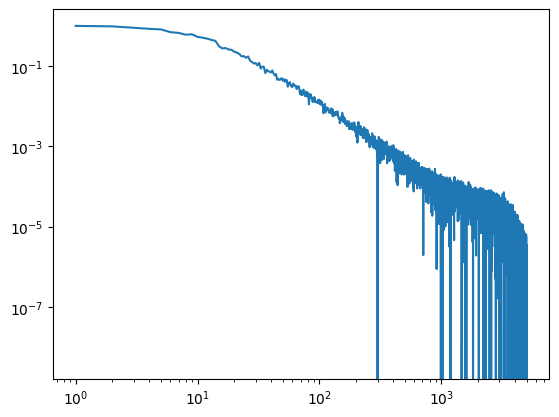

In [174]:
plt.loglog(qe_cross_it_split[-1][0]/input_[0])

In [180]:
WF_a = input_[0] * utils.cli(input_[0] + n_gg[:5001])

/tmp/ipykernel_5200/509844325.py:1: RuntimeWarning: invalid value encountered in divide
  WF = qe_cross_it_split[-1][0]/input_[0]


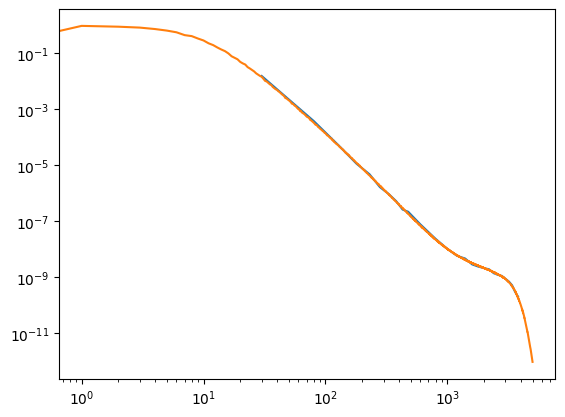

In [190]:
WF = qe_cross_it_split[-1][0]/input_[0]
el, wfx = decorator(WF)


plt.plot(el, wfx**2)
plt.loglog(WF_a**2)

/tmp/ipykernel_5200/1733104174.py:16: RuntimeWarning: invalid value encountered in divide
  iWF = t/c


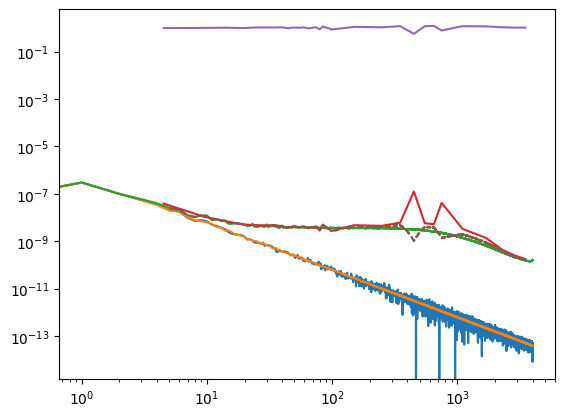

In [250]:
t = np.load("/users/odarwish/cmblensplus/example/curvedsky_reconstruction/cl_th.npy")
c = np.load("/users/odarwish/cmblensplus/example/curvedsky_reconstruction/cl_all.npy")
a = np.load("/users/odarwish/cmblensplus/example/curvedsky_reconstruction/cl_auto.npy")
t = t.mean(axis = 0)
c = c.mean(axis = 0)
a = a.mean(axis = 0)
plt.loglog(c)
plt.loglog(t)
plt.loglog(a)

bin_edges_B = np.arange(2, 100, 5)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])

decorator = lambda x: bin_theory(x, bin_edges)

iWF = t/c
xx = a*iWF**2
el, x = decorator(xx)
plt.plot(el, x)

el, xx = decorator(iWF)
plt.plot(el, xx)
#interpolate xx with scipy
import scipy.interpolate

f = scipy.interpolate.interp1d(el, xx, kind = "linear", bounds_error = False)
ls = np.arange(a.size)
el, x = decorator(a)
plt.plot(ls, f(ls)**2*a, ls = "--")
#el, x = decorator(f(ls)**2*a)
#plt.plot(el, x, lw = 2)

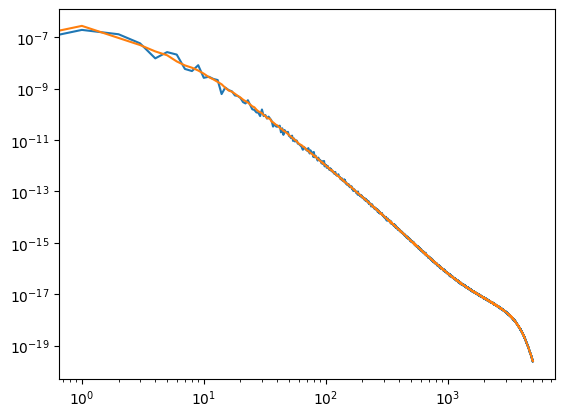

In [214]:
plt.loglog(qe_it_single_split[-1][0])
plt.plot(qe_it_split[-1][0])

/tmp/ipykernel_5200/3642441056.py:4: RuntimeWarning: invalid value encountered in divide
  invWF = input_[0]/qe_cross_it_split[-1][0]


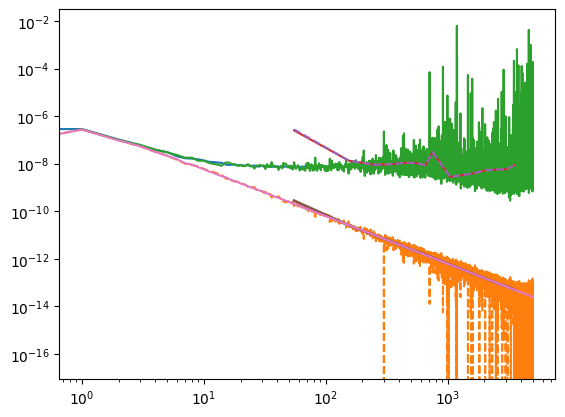

In [241]:
plt.plot(qe_split[-1])
plt.plot(qe_cross_split[-1], ls = "--")

invWF = input_[0]/qe_cross_it_split[-1][0]
el, iwfx = decorator(invWF)
#invWF = WF_a**-1.
xx = qe_it_split[-1][0]
plt.plot(xx*invWF**2)
el, x = decorator(xx)
plt.plot(el, iwfx**2*x)
el, xsingle = decorator(qe_it_single_split[-1][0])
plt.plot(el, iwfx**2*xsingle, ls = "--")

el, x = decorator(qe_cross_split[-1][2:])
plt.plot(el, x, lw = 2)

plt.plot(input_[0])
plt.yscale("log")
plt.xscale("log")
#plt.xlim(10, 1000)

/tmp/ipykernel_5200/881850102.py:1: RuntimeWarning: invalid value encountered in divide
  el, x = decorator(cross_split[-1][0]/input_[0])
/tmp/ipykernel_5200/881850102.py:5: RuntimeWarning: invalid value encountered in divide
  el, x = decorator(cross_split[-1][-1]/input_[0])


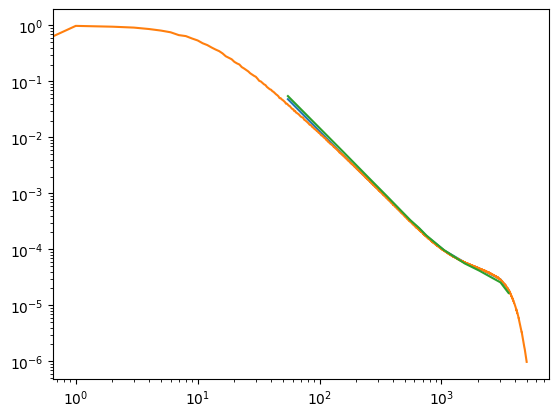

In [242]:
el, x = decorator(cross_split[-1][0]/input_[0])
plt.loglog(el, x)
plt.plot(WFth)

el, x = decorator(cross_split[-1][-1]/input_[0])
plt.loglog(el, x)
#plt.plot(WFth10)

/tmp/ipykernel_22730/2343850915.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  corr = WFth**-1#
/tmp/ipykernel_22730/2343850915.py:11: RuntimeWarning: invalid value encountered in multiply
  el, x = decorator(autos_split[-1][itr]*corr**2.-input_[0]-n1_ap[:5001])


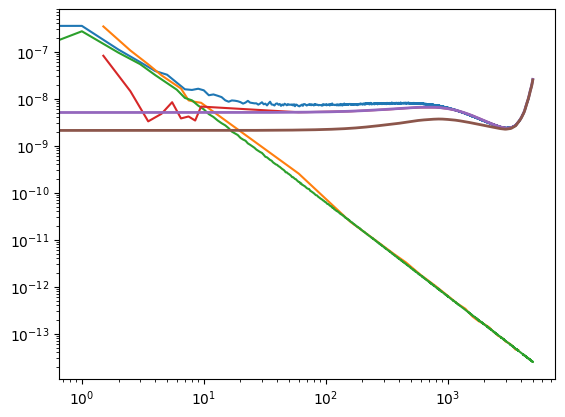

In [101]:
itr = 0

corr = WFth**-1#
#corr = input_[0]/cross_split[-1][itr]

plt.loglog(qe_split[-1])
el, x = decorator(qe_cross_split[-1])
plt.loglog(el, x)
plt.loglog(input_[0])

el, x = decorator(autos_split[-1][itr]*corr**2.-input_[0]-n1_ap[:5001])
plt.plot(el, x)


plt.plot(ngg, lw = 2, label = "Nth iter 10")
plt.plot(ngg_10, lw = 2, label = "Nth iter 10")

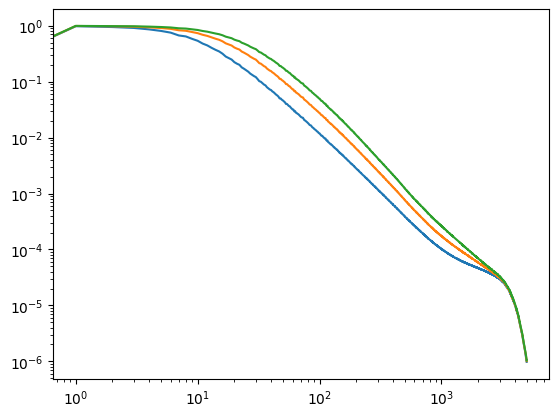

In [17]:
ngg = np.loadtxt("ngg_a.txt")[:5001]
n1_ap = np.loadtxt("n1_ap.txt")[:5001]

ngg_1 = np.loadtxt("ngg_a_itr_1.txt")[:5001]
ngg_10 = np.loadtxt("ngg_a_itr_10.txt")[:5001]
ngg_unl = np.loadtxt("ngg_a_itr_unl.txt")[:5001]

WFth = input_[0]/(input_[0]+ngg)
WFth10 = input_[0]/(input_[0]+ngg_10)
WFthunl = input_[0]/(input_[0]+ngg_unl)

plt.loglog(WFth)
plt.loglog(WFth10)
plt.plot(WFthunl)

/tmp/ipykernel_5200/2267914619.py:4: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[i][itr]/inputs[i]


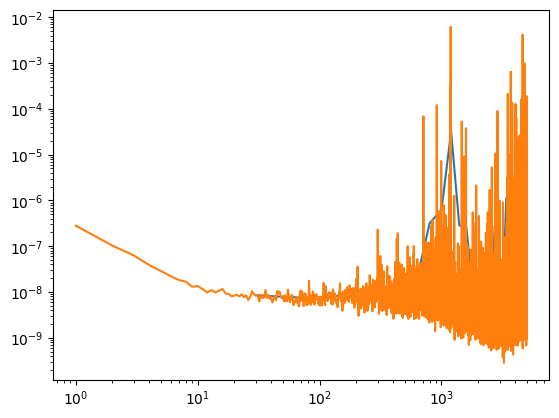

In [147]:
i = 2
itr = 0

WF = cross_split[i][itr]/inputs[i]

#plt.loglog(WF)


xx = autos_split[i][itr]*WF**-2.#-inputs[i]-n1_ap[:5001]
el, x = decorator(xx)
plt.plot(el, x)
plt.loglog(autos_split[i][itr]*WF**-2.)

In [22]:
config_paths = ["alpha_after_lensing_sims", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation", "config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est"]#,  "config_full_no_alpha_no_curl_lensing_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]
config_paths

['configs/alpha_after_lensing_sims.yaml',
 'configs/config_full_alpha_disabled_lensing_cmb_s4_new_rotation.yaml',
 'configs/config_full_alpha_disabled_lensing_cmb_s4_new_rotation_no_curl_est.yaml']

In [56]:
bin_edges_B = np.arange(2, 100, 1)
bin_edges = np.concatenate([bin_edges_B, np.arange(100, 800, 100), np.arange(800, 4000, 600)])

decorator = lambda x: bin_theory(x, bin_edges)

bin_edges

array([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,   12,
         13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
         24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,
         35,   36,   37,   38,   39,   40,   41,   42,   43,   44,   45,
         46,   47,   48,   49,   50,   51,   52,   53,   54,   55,   56,
         57,   58,   59,   60,   61,   62,   63,   64,   65,   66,   67,
         68,   69,   70,   71,   72,   73,   74,   75,   76,   77,   78,
         79,   80,   81,   82,   83,   84,   85,   86,   87,   88,   89,
         90,   91,   92,   93,   94,   95,   96,   97,   98,   99,  100,
        200,  300,  400,  500,  600,  700,  800, 1400, 2000, 2600, 3200,
       3800])

/tmp/ipykernel_23867/2186833718.py:32: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[i][itr]/inputs[i]
/tmp/ipykernel_23867/2186833718.py:46: RuntimeWarning: divide by zero encountered in power
  plt.plot(autos_split[i][itr]*WFth**-2., color = "green")
/tmp/ipykernel_23867/2186833718.py:46: RuntimeWarning: invalid value encountered in multiply
  plt.plot(autos_split[i][itr]*WFth**-2., color = "green")
/tmp/ipykernel_23867/2186833718.py:50: RuntimeWarning: divide by zero encountered in power
  el, xy = decorator(autos_split[i][itr]*WFth**-2.)
/tmp/ipykernel_23867/2186833718.py:50: RuntimeWarning: invalid value encountered in multiply
  el, xy = decorator(autos_split[i][itr]*WFth**-2.)


b


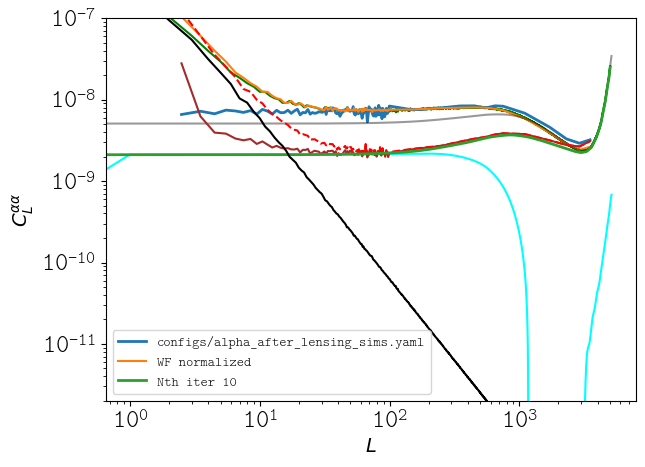

In [57]:
selected = ["p", "o", "a"]

invWFs = {}


for i, s in enumerate(selected):
    if i < 2:
        continue

    for j, config_path in enumerate(config_paths[:1]):
        selected, autoits, crossits, auto_input_its, _, _ = process_config_npy(config_path)

        autos = autoits.mean(axis = 0)
        crosses = crossits.mean(axis = 0)
        inputs = auto_input_its.mean(axis = 0)

        autos_split = np.split(autos, len(selected), axis = -1)
        cross_split = np.split(crosses, len(selected), axis = -1)

        """plt.loglog(cross_split[0][0]*WFth**-1.)

        plt.loglog(cross_split[0][-1]*WFth10**-1.)

        plt.loglog(inputs[0])
        plt.show()"""


        for itr in [0, autos.shape[0]-1]:
            
            i = 2

            WF = cross_split[i][itr]/inputs[i]
            
            if itr == 0:
                WFQE = WF
            invWF = WF**-1.
            if j == 0:
                invWFs[s] = invWF
            #xx = autos_split[i][itr]*invWFs[s]**2.-inputs[i]
            xx = autos_split[i][itr]*WF**-2.-inputs[i] #-inputs[i]-n1_ap[:5001]
            el, x = decorator(xx)

            if itr == 0:
                
                #plt.plot(autos_split[i][itr]*WFth**-2.-nggs["a"][:5001]-inputs[i], color = "green")
                plt.plot(autos_split[i][itr]*WFth**-2., color = "green")
                plt.plot(el, x, lw = 2, label= config_path)
                
                #el, xy = decorator(autos_split[i][itr]*invWFs[s]**2.)
                el, xy = decorator(autos_split[i][itr]*WFth**-2.)
                plt.plot(el, xy, label = "WF normalized")
                np.savetxt("x.txt", np.c_[el, xy])

                
                #el, xy = decorator(qe_alpha)
                #plt.plot(el, xy, ls = "--", label = "QE normalized")

            else:
                el, x = decorator(autos_split[i][itr]*WF**-2.-inputs[i])
                plt.plot(el, x, color = "brown")
                el, x = decorator(autos_split[i][itr]*WF**-2.)
                plt.plot(el, x, color = "red", ls = "--")
                plt.plot(ngg_10, lw = 2, label = "Nth iter 10")

                
            #plt.loglog(el, x, lw = 2, label= config_path)

            if itr == 0:
                i = 0
                xx = 0
                #ff = np.split(fs[i], 3)[xx]
                #ff1000 = np.split(fs1000[i], 3)[xx]
                #np.savetxt("corr.txt", invWFs[s])
                #xx = ffmean[:5001]*invWFs[s]**2-inputs[i]
                #el, x = decorator(xx)
                #plt.loglog(el, x, lxs = "--")

                xx = autoits[i][0][:5001]*invWFs[s]**2-inputs[i]
                el, x = decorator(xx)
                #plt.loglog(el, x, ls = "--", color = "black")
                n1_ap = np.loadtxt("n1_ap.txt")
                plt.plot(n1_ap, color = "cyan")
                plt.plot(nggs["a"], color = "black", alpha = 0.4)
                #plt.plot(n0_bb, ls = "--")

                #xx = ff1000means[0][:5001]*WFth**-2.
                #el, x = decorator(xx)
                #np.savetxt("xrand.txt", np.c_[el, x])
                #plt.loglog(el, x, ls = ":")
                #plt.loglog(n1_bb**-1.)
            else:
                #xx = ff1000means[1][:5001]*invWF**2.
                #el, x = decorator(xx)
                #plt.loglog(el, x, ls = ":")
                pass



        plt.plot(inputs[i], color = "black")
        #plt.plot(nggs[s], lw = 2)
        #plt.plot(n0_bb)
        #plt.title(s)
        print(a)
        #plt.xlim(5, 2000)
        #plt.savefig("")
        plt.yticks(fontsize = 18)
        plt.xticks(fontsize = 18)
        plt.xlabel(r"$L$", fontsize = 14)
    if s == "a":
        plt.ylabel(r"$C_L^{\alpha\alpha}$", fontsize = 14)
        plt.ylim(2e-12, 1e-7)
        plt.tight_layout()
        plt.xscale("log")
        plt.yscale("log")
        plt.legend()
        plt.savefig("alpha.png", dpi = 300)
    plt.show()

/tmp/ipykernel_23867/2365046883.py:3: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[i][0]/inputs[i]
/tmp/ipykernel_23867/2365046883.py:7: RuntimeWarning: invalid value encountered in divide
  WF = cross_split[i][-1]/inputs[i]


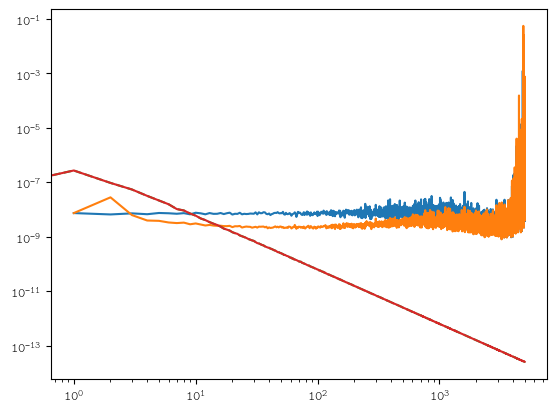

In [58]:
i = 2

WF = cross_split[i][0]/inputs[i]
plt.loglog(autos_split[i][0]*WF**-2.-inputs[i])


WF = cross_split[i][-1]/inputs[i]
plt.loglog(autos_split[i][-1]*WF**-2.-inputs[i])

plt.loglog(inputs[2], ls = "--")

plt.plot(input_[0])
plt.show()

/tmp/ipykernel_24685/4261179546.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(cross_split[0][0]**2./(autos_split[0][0]*inputs[0]))
/tmp/ipykernel_24685/4261179546.py:2: RuntimeWarning: invalid value encountered in divide
  plt.plot(cross_split[0][-1]**2./(autos_split[0][-1]*inputs[0]))


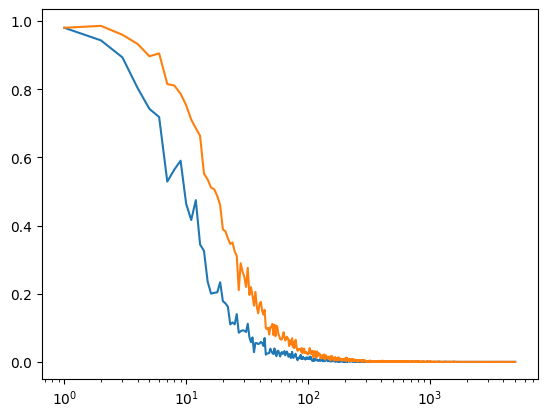

In [31]:
plt.plot(cross_split[0][0]**2./(autos_split[0][0]*inputs[0]))
plt.plot(cross_split[0][-1]**2./(autos_split[0][-1]*inputs[0]))

plt.xscale("log")

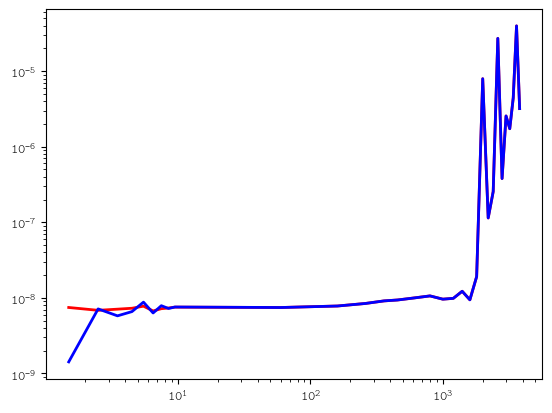

In [20]:
el, x = np.loadtxt("x.txt").T
plt.plot(el, x, lw = 2, color = "red")

el, x = np.loadtxt("x63.txt").T
plt.loglog(el, x, lw = 2, color = "blue")

/tmp/ipykernel_17130/2759033551.py:7: RuntimeWarning: invalid value encountered in divide
  correction = hp.alm2cl(alpha_lm)/hp.alm2cl(alpha_lm, ff)


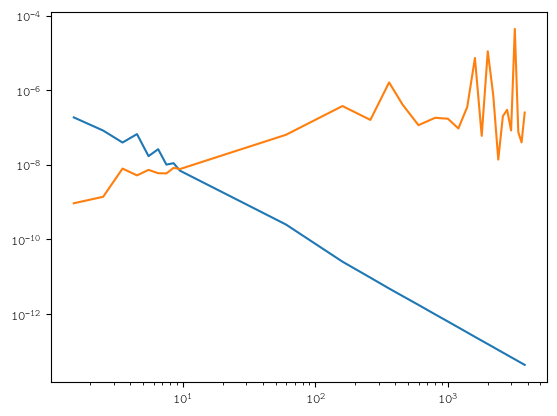

In [35]:
i = 0
xx = 0

ff = np.split(fs[i], 3)[xx]
ff1000 = np.split(fs1000[i], 3)[xx]

correction = hp.alm2cl(alpha_lm)/hp.alm2cl(alpha_lm, ff)

N0 = hp.alm2cl(ff1000)*correction**2

input = hp.alm2cl(alpha_lm)
el, clth = decorator(input)
plt.loglog(el, clth)
el, cl = decorator(hp.alm2cl(ff)*correction**2-input)
plt.loglog(el, cl)

In [24]:
bin_edges = np.arange(0, 1500, 10)
def cross_corr_coeff_new(a1a2, a1, a2, base=0, color=None, plot=True, ax=None, label=None, linestyle = None):
    ls = np.arange(len(a1))
    decorator = lambda x: bin_theory(x, bin_edges)
    el, x = decorator(a1a2)
    el, aa = decorator(a1)
    el, bb = decorator(a2)
    xcorr = x**2 / (aa * bb)
    if plot and ax is not None:
        ax.plot(el, xcorr - base, color=color, label=label, linestyle = linestyle)
    return el, xcorr

In [47]:
config_paths = ["config_full_cmb_s4",  "config_full_a_d_disabled_cmb_s4"]
config_paths = [f"configs/{config}.yaml" for config in config_paths]

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=len(selected), figsize = (16, 6), sharex = True)

names = {"o": r"$\hat{\omega}$", "a": r"$\hat{\alpha}$", "p": r"$\hat{\phi}$", "f": r"$\hat{\tau}$"}
names_down = {"o": r"$\hat{\omega}-\alpha$", "a": r"$\hat{\alpha}-\omega$", "p": r"$\hat{\phi}-\tau$", "f": r"$\hat{\tau}-\phi$"}

colors = {0: "blue", 1: "red", 2: "green"}
lines = {0: "-", 1: "--"}

labels = lambda x: "QE" if x == 0 else "MAP"


for j, config_path in enumerate(config_paths):
    selected, autoits, crossits, auto_input_its, crossits_down, auto_input_down_its = process_config_npy(config_path)   


    autos = autoits.mean(axis = 0)
    crosses = crossits.mean(axis = 0)
    crosses_down = crossits_down.mean(axis = 0)
    inputs = auto_input_its.mean(axis = 0)
    inputs_down = auto_input_down_its.mean(axis = 0)

    autos_split = np.split(autos, len(selected), axis = -1)
    cross_split = np.split(crosses, len(selected), axis = -1)
    cross_down_split = np.split(crosses_down, len(selected), axis = -1)

    for i, s in enumerate(selected):
        ax = axs[0, i]
        ax.set_title(names[s], fontsize = 20)
        a1 = inputs[i]
        for itr in [0, 11]:
            a2 = autos_split[i][itr]
            a12 = cross_split[i][itr]
            
            if itr == 0:
                cross_corr_coeff_new(a12, a1, a2, ax = ax, linestyle = lines[j], color = "green", label = labels(itr))
            else:
                cross_corr_coeff_new(a12, a1, a2, ax = ax, linestyle = lines[j], color = colors[j], label = labels(itr))
        if (i == 0) and (j == 0):
            ax.legend()
        ax.set_xscale("log")
        ax.set_xlim(1, 3000)
        ax.tick_params(axis='both', labelsize=18)

        ax = axs[1, i]
        ax.set_title(names_down[s], fontsize = 20)
        a1 = inputs_down[i]
        for itr in [0, 15]:
            a2 = autos_split[i][itr]
            a12 = cross_down_split[i][itr]
            if itr == 0:
                cross_corr_coeff_new(a12, a1, a2, ax = ax, linestyle = lines[j], color = "green", label = labels(itr))
            else:
                cross_corr_coeff_new(a12, a1, a2, ax = ax, linestyle = lines[j], color = colors[j], label = labels(itr))

        ax.set_xscale("log")
        ax.set_xlim(5, 3000)
        ax.tick_params(axis='both', labelsize=18)


fig.tight_layout()
plt.savefig("cross-corr.png", dpi = 300)
plt.show()

In [ ]:
for i, s in enumerate(selected):

    for j, config_path in enumerate(config_paths):
        selected, autoits, crossits, auto_input_its = process_config_npy(config_path)

        autos = autoits.mean(axis = 0)
        crosses = crossits.mean(axis = 0)
        inputs = auto_input_its.mean(axis = 0)

        autos_split = np.split(autos, len(selected), axis = -1)
        cross_split = np.split(crosses, len(selected), axis = -1)

        for itr in [0, autos.shape[0]-1]:
            WF = -cross_split[i][itr]/inputs[i]
            invWF = WF**-1.
            if j == 0:
                invWFs[s] = invWF
            xx = autos_split[i][itr]*invWFs[s]**2.-inputs[i]
            el, x = decorator(xx)
            plt.loglog(el, x, lw = 2, label= config_path)
        plt.plot(inputs[i], color = "black")
        #plt.plot(nggs[s], lw = 2)
        #plt.plot(n0_bb)
        #plt.title(s)
        print(a)
        plt.xlim(5, 2000)
        #plt.savefig("")
        plt.yticks(fontsize = 18)
        plt.xticks(fontsize = 18)
        plt.xlabel(r"$L$", fontsize = 14)
    if s == "a":
        plt.ylabel(r"$C_L^{\alpha\alpha}$", fontsize = 14)
        plt.ylim(2e-10, 1e-7)
        plt.tight_layout()
        plt.legend()
        plt.savefig("alpha.png", dpi = 300)
    plt.show()